# Problem definition
The goal of this jupyter notebook is to develop a digit recogniser from audio input. Just like in the problem description, audio in digit out - fast, clean, and functional. Happy coding

This notebook will cover the experiment part of the larger project. That means at the end of the notebook, I should have a model that takes in audio inputs and returns the digit

## Requirements : 
- Datasets: The recommended datasets can be found on 🤗
- Tools, my favourite PyTorch and

Let's get to work ⚒️
- [x] Load datasets
- [ ] Data preprocessing
- [ ] Model
- [ ] Training
- [ ] Evaluation

## Config

In [1]:
# Dataset
DATASET_NAME = "mteb/free-spoken-digit-dataset"
TRAIN_SPLIT = 0.7

# mel spectrogram
SAMPLE_RATE = 8000
N_FFT = 256
HOP_LENGTH = 128
N_MELS = 40

# dataset
BATCH_SIZE = 32


## import libraries

In [2]:
from datasets import load_dataset
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt


import torch
import torchaudio
import torchaudio.transforms as T
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## Load the datasets 

The dataset is the mteb free spoken digit datasets, containing audio and digit pairs. I will load and divide the dataset into train, val and test samples using the datasets library. The datasets load_dataset returns a DatasetDict object where each key maps to the Dataset class

- load the datasets
- create a `train, valid and test split` from the `ds`


In [4]:

# load the FSDD from hugging face
ds = load_dataset(DATASET_NAME)

README.md:   0%|          | 0.00/632 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.98M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2700 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/300 [00:00<?, ? examples/s]

In [5]:
train_valid_ds = ds['train'].train_test_split(test_size = (1-TRAIN_SPLIT))
train_ds = train_valid_ds['train']
valid_ds = train_valid_ds['test']
test_ds = ds['test']

In [6]:
print("Train:", len(train_ds))
print("Validation:", len(valid_ds))
print("Test:", len(test_ds))

Train: 1889
Validation: 811
Test: 300


### information about the dataset

let's look deeper into 👀 into the dataset what does the audio and label look like


In [7]:
one_sample = train_ds[999]
audio, label = one_sample['audio'], one_sample['label']
audio_array = audio['array']
print(f'type of audio array is: {type(audio_array)}')
print(f"size of audio array: {audio_array.shape}")
print(f"array: {audio_array[:10]}...(truncated)")
print(f"sampling rate: {audio['sampling_rate']}")

type of audio array is: <class 'numpy.ndarray'>
size of audio array: (3485,)
array: [ 0.        -0.0078125  0.        -0.0078125  0.        -0.0078125
  0.        -0.0078125  0.        -0.0078125]...(truncated)
sampling rate: 8000


so audio is also a dict containing the `path` to an .wav file, a 1 dimensional numpy `array` and  a `sampling_rate` we will look into this more in a bit

- `array`: it is a digital representation of the sound(wave) it is represented as a one dimensional array of floating values ranging -1 and +1. this is gotten by sampling the original sound wave (analogue) at a constant time interval, after the sampled values are then converted from continues to discrete values. the sampled magnitude of this values are the amplitude of the sound wave.
- `sampling_rate`: is the number of samples that were taken per second in this case 8000 sample audio audio wave were sampled in one second

### take a listen to the audio 🎧

Ipython provides a class `Audio` which takes in the audio array and provide a cool interface to listen to the sound through our microphone we see that below

In [18]:

sample = train_ds[0]
print("Label:", sample["label"])
ipd.Audio(sample["audio"]["array"], rate=sample["audio"]["sampling_rate"])


Label: 8


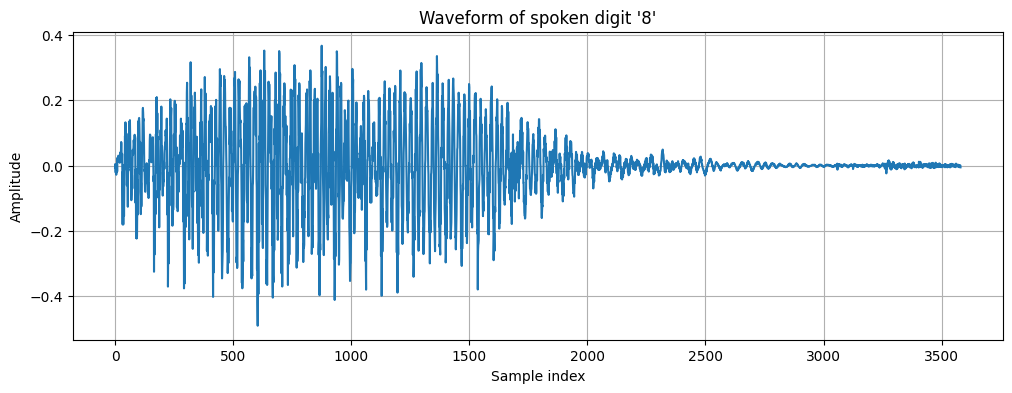

In [21]:


plt.figure(figsize=(12, 4))
plt.plot(sample["audio"]["array"])
plt.title(f"Waveform of spoken digit '{sample['label']}'")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [16]:
import IPython.display as ipd
import matplotlib.pyplot as plt
sample = train_ds[100]
print("Label:", sample["label"])
ipd.Audio(sample["audio"]["array"], rate=sample["audio"]["sampling_rate"])


Label: 2


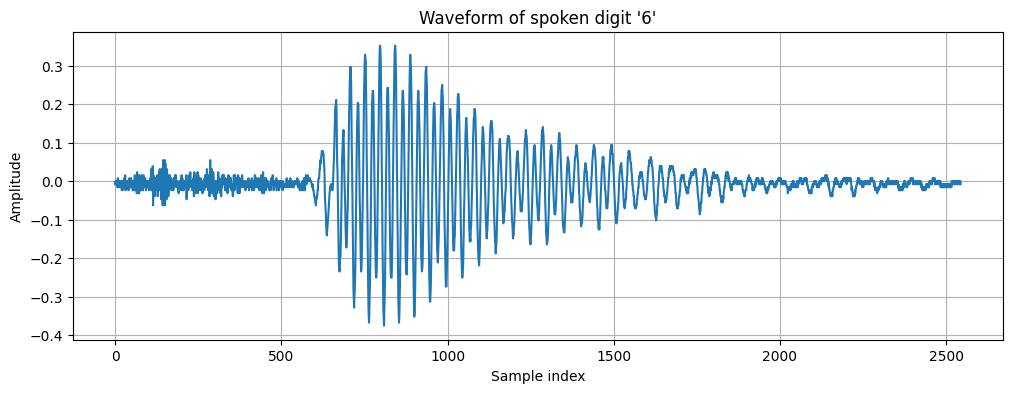

In [17]:


plt.figure(figsize=(12, 4))
plt.plot(sample["audio"]["array"])
plt.title(f"Waveform of spoken digit '{label}'")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

## Preprocessing

`sampling_rate`: as we have establish earlier that it is samples per sec when digitizing the audio wave, we can then say that a 1 sec audio with sampling rate of 8000 will have 8000 float values. we need to ensure that all samples are of the same sampling rate for the following reasons:

- consistency in representation: we want to ensure that all samples that we will feed into our model have the same representation and can be seen by the model fairly. A 1-second audio clip at 8 kHz has 8,000 samples, The same clip at 16 kHz has 16,000 samples when feed both into a neural net without adjustment, the model will see different input lengths and frequency content
- consistent shape


how do we determine what the sampling frequency to use well. we can use Nyquist Theorem which.

- need a sampling rate >= 2 * the higest frequency we want to capture
- spoken digits most od the important speech information is below 4 kHz so therefore 8kHz is sufficient since fmax = 4kHz

we don't need to do this ourselves because all the samples in our datasets are sampled at 8kHz

In [15]:
# Check unique sampling rates
sampling_rates = set([s["audio"]["sampling_rate"] for s in train_ds])
print("Unique sampling rates in training set:", sampling_rates)
valid_sampling_rates = set([s["audio"]["sampling_rate"] for s in valid_ds])
print("Unique sampling rates in valid set:", valid_sampling_rates)
test_sampling_rates = set([s["audio"]["sampling_rate"] for s in test_ds])
print("Unique sampling rates in test set:", test_sampling_rates)

Unique sampling rates in training set: {8000}
Unique sampling rates in valid set: {8000}
Unique sampling rates in test set: {8000}


`normalization`: we can add some normalization

In [13]:
# incase a we have an audio that is not sampled at 8kHz

def preprocess_audio(example):
    # Load array
    audio = example["audio"]["array"]
    sr = example["audio"]["sampling_rate"]

    # Resample if needed
    if sr != SAMPLE_RATE:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=SAMPLE_RATE)

    example["array"] = audio
    example["sampling_rate"] = SAMPLE_RATE
    example["label"] = int(example["label"])  # ensure numeric

    return example


### Other preprocessing to consider
- Silence trimming: Spoken digits may have leading/trailing silence, Trimming helps the model focus only on the digit.
- Adding background noise (white noise, crowd, etc.), time stretching or pitch shifting this helps generalize to real-world audio.

### Feature Extraction
A little on why this is so important recall initially I mentioned that our audio arays are amplitude values sampled at 1 seconds. This values are changes in air pressure over time but the usually the difference between two digits are hidden in the frequncy content of the signal rather than in raw amplitude values. so there fore we need to transform our signal into the frequncy domain to have a more better representation. to achieve this we we will:
- we transform it into the frequency domain using the short-time Fourier transform (STFT). This gives us a spectrogram: how much energy exists at each frequency over time.
- After then we take it a step further and map frequencies onto the Mel scale. This helps us to mimic how humans perceive pitch differences—more detail at low frequencies where speech formants live, and less at very high frequencies where our ears are less sensitive.



<img src="https://github.com/daunsid/digit-recognizer/blob/main/imgs/mel_spectrogram.png?raw=true" width="300">

$$
\text{Waveform } x[n] \xrightarrow{\text{STFT}} X_m[k] \xrightarrow{|\cdot|} |X_m[k]| \xrightarrow{\text{Mel filters}} S_m[i] \xrightarrow{\log} S_\text{dB}[i, m]
$$

* **Input:** 1D waveform
* **Output:** 2D matrix `[n_mels, time_frames]` ready for model input


Mathematically this process is represented as follows: for each sample:


**1. Short-Time Fourier Transform (STFT)** Given an audio sample $x[n]$ (waveform), we first split it into overlapping windows of length $N_\text{FFT}$ and compute the FFT for each window as follows:

$$
X_m[k] = \sum_{n=0}^{N_\text{FFT}-1} w[n] \, x[n + m \cdot \text{hop\_length}] \, e^{-j 2 \pi k n / N_\text{FFT}}
$$

Where:

* $w[n]$ = window function (e.g., Hann window)
* $m$ = frame index (time step)
* $k$ = frequency bin index
* `hop_length` = number of samples to shift the window

This produces a **complex-valued matrix** $X \in \mathbb{C}^{\text{n\_fft/2+1} \times T}$, where $T$ is the number of frames.

**2. Magnitude Spectrum** Next we take the magnitude (discard phase) for each STFT coefficient:

$$
|X_m[k]| = \sqrt{\operatorname{Re}(X_m[k])^2 + \operatorname{Im}(X_m[k])^2}
$$

This gives a real-valued spectrogram.


**3. Mel Filter Bank** The frequency bins $k$ are mapped to **Mel scale** to match human auditory perception:

$$
m(f) = 2595 \cdot \log_{10}\left(1 + \frac{f}{700}\right)
$$

* $f$ = frequency in Hz
* The STFT bins are multiplied by triangular Mel filters $H_{mel}[k, i]$ to produce Mel band energies:

$$
S_m[i] = \sum_{k=0}^{N_\text{FFT}/2} |X_m[k]| \cdot H_{mel}[k, i]
$$

Where $i = 1 \dots N_\text{MELS}$ (number of Mel bands).

**4. Convert to Decibels (log scale)**

Finally, we convert the amplitude to **log scale**:

$$
S_\text{dB}[i, m] = 10 \cdot \log_{10} \big(S_m[i] + \epsilon\big)
$$

* $\epsilon$ = small constant to avoid log(0)
* This step compresses dynamic range and better reflects human loudness perception.

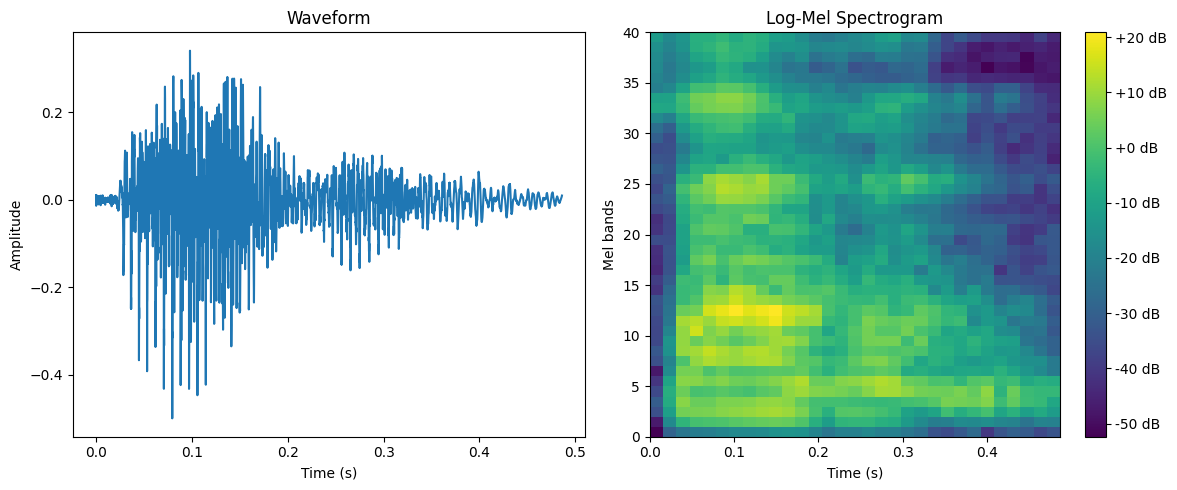

In [11]:
y = torch.from_numpy(audio_array)
y = y.squeeze().float()


mel_spectrogram = T.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH,
    n_mels=N_MELS
)
amplitude_to_db = T.AmplitudeToDB()


S = mel_spectrogram(y)
S_dB = amplitude_to_db(S)


plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(torch.arange(y.shape[0]) / SAMPLE_RATE, y.numpy())
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")


plt.subplot(1, 2, 2)
plt.imshow(S_dB.numpy(), origin='lower', aspect='auto', cmap='viridis', 
           extent=[0, y.shape[0] / SAMPLE_RATE, 0, N_MELS])
plt.title("Log-Mel Spectrogram")
plt.xlabel("Time (s)")
plt.ylabel("Mel bands")
plt.colorbar(format="%+2.0f dB")

plt.tight_layout()
plt.show()


In [12]:

def plot_digits_waveform_and_mel(samples, mel_spectrogram, amplitude_to_db):
    """
    Plots the raw waveform and log-mel spectrogram for digits 0–9.
    
    Args:
        samples: list of dataset samples (one per digit, 0–9).
        mel_spectrogram: torchaudio.transforms.MelSpectrogram instance.
        amplitude_to_db: torchaudio.transforms.AmplitudeToDB instance.
    """
    
    num_digits = len(samples)
    fig, axes = plt.subplots(num_digits, 2, figsize=(10, 2*num_digits))
    fig.suptitle("Waveform vs Log-Mel Spectrogram for Digits 0–9", fontsize=16, y=1.02)

    for i, sample in enumerate(samples):
        waveform = torch.tensor(sample["audio"]["array"]).float()
        label = sample["label"]

        # Compute log-mel spectrogram
        mel = mel_spectrogram(waveform)
        mel_db = amplitude_to_db(mel)

        # Plot waveform
        axes[i, 0].plot(waveform.numpy())
        axes[i, 0].set_title(f"Digit {label} - Waveform")
        axes[i, 0].set_xlabel("Time (samples)")
        axes[i, 0].set_ylabel("Amplitude")

        # Plot log-mel spectrogram
        im = axes[i, 1].imshow(mel_db.numpy(), origin="lower", aspect="auto", cmap="magma")
        axes[i, 1].set_title(f"Digit {label} - Log-Mel Spectrogram")
        axes[i, 1].set_xlabel("Time (frames)")
        axes[i, 1].set_ylabel("Mel bands")

    plt.tight_layout()
    plt.show()


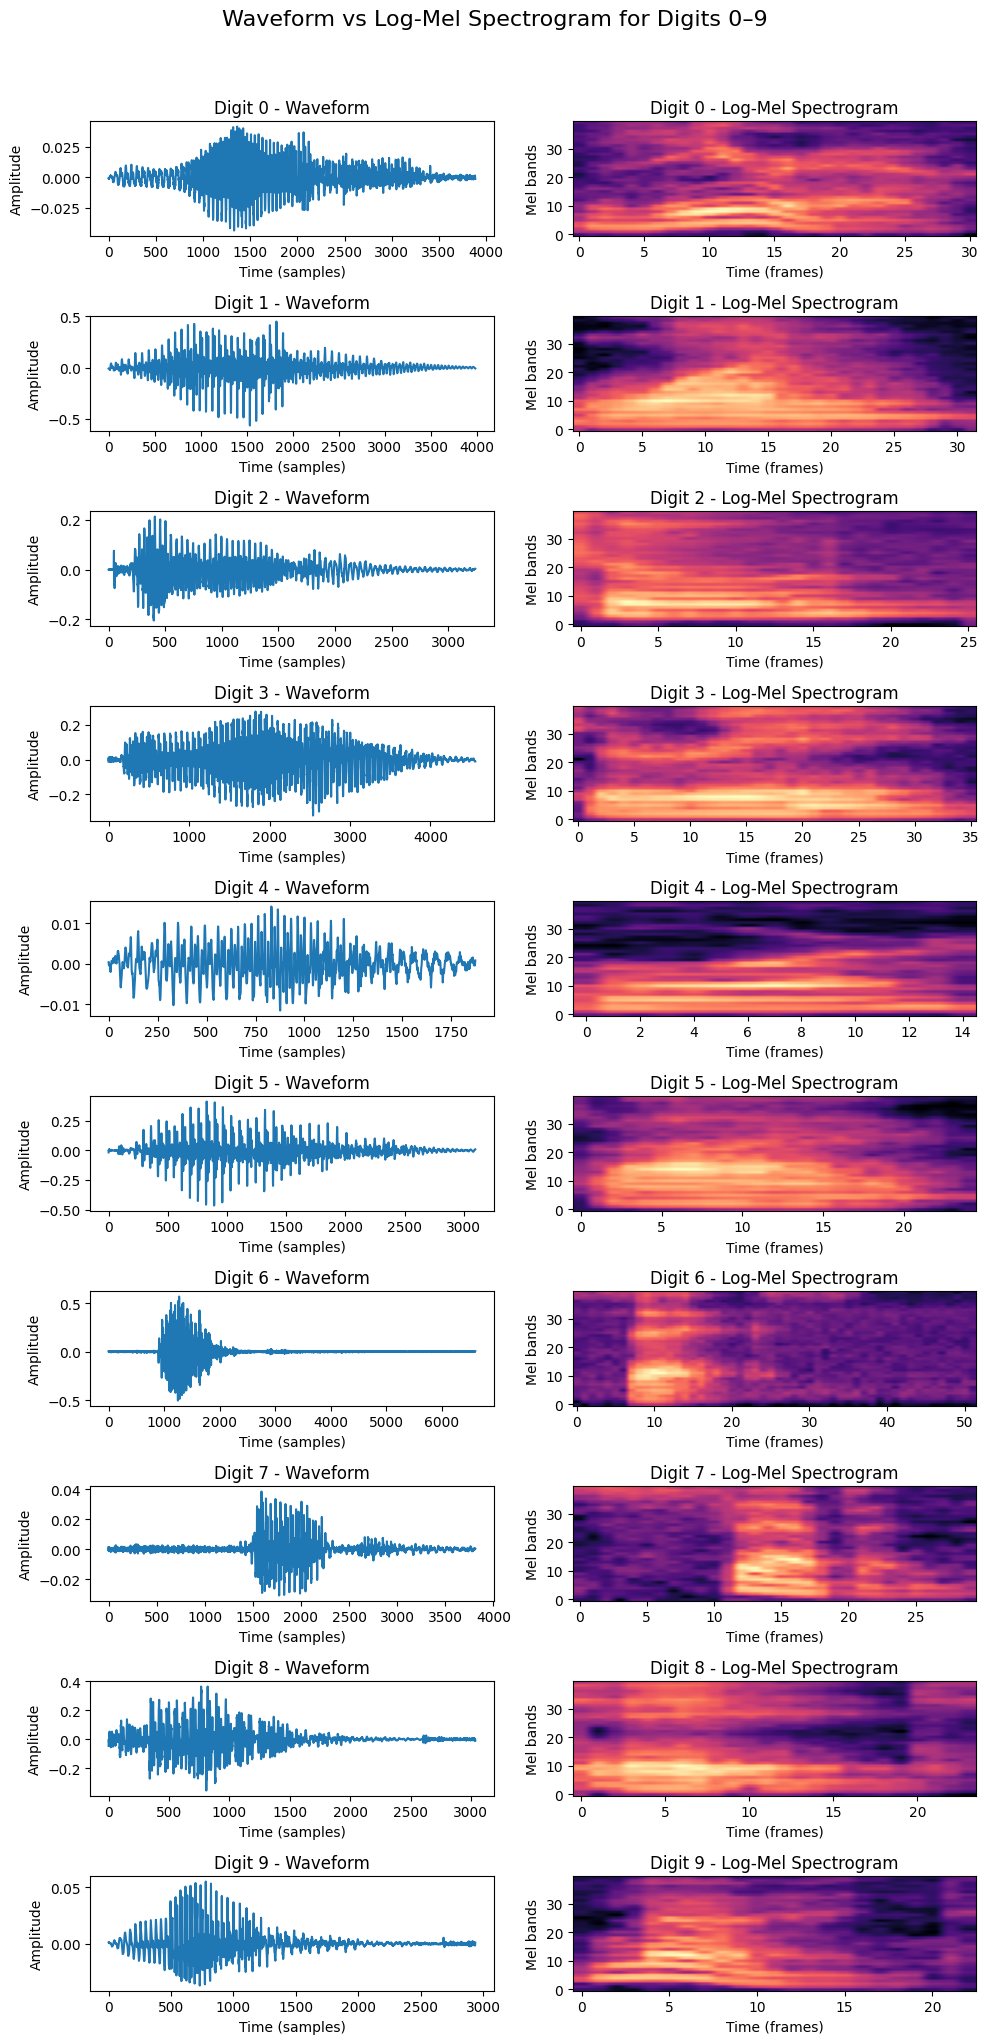

In [17]:
samples_0_to_9 = [train_ds[int(np.where(np.array(train_ds["label"]) == d)[0][0])] for d in range(10)]
plot_digits_waveform_and_mel(samples_0_to_9, mel_spectrogram, amplitude_to_db)


In [8]:


class SpokenDigitDataset(Dataset):
    def __init__(self, hf_dataset, transform=None, target_transform=None):
        """
        Args:
            hf_dataset: Hugging Face dataset split (train/test).
            transform: function/transform applied to audio waveform (e.g., mel spectrogram).
            target_transform: optional transform for labels.
        """
        self.dataset = hf_dataset
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[int(idx)]
        waveform = torch.tensor(sample["audio"]["array"]).float()
        label = sample["label"]

        if self.transform:
            waveform = self.transform(waveform)

        if self.target_transform:
            label = self.target_transform(label)

        return waveform, torch.tensor(label, dtype=torch.long)


# def collate_fn(batch):
#     features, labels = zip(*batch)

#     # Find max time length in this batch
#     max_len = max(f.shape[1] for f in features)

#     # Pad all to same length (right-pad with zeros)
#     padded_features = torch.stack([
#         torch.nn.functional.pad(f, (0, max_len - f.shape[1]))
#         for f in features
#     ])

#     labels = torch.stack(labels)
#     return padded_features, labels


The preprocessing step include:
1. Scaling the original waveform: simply dividing by the maximum absolute value in the waveform this helps us to maintain positive and negative amplitude while also ensuring that the amplitude does not vary to wildly
2. 

In [73]:

import torch.nn as nn
class Preprocess(nn.Module):
    def __init__(self, sample_rate=8000, n_fft=256, hop_length=128, n_mels=40, max_len=16000):
        """
        Args:
            sample_rate: Target sample rate for audio
            n_fft: Number of FFT bins
            hop_length: Hop length for STFT
            n_mels: Number of Mel filterbanks
            max_len: Maximum waveform length in samples for padding/truncating
        """
        super().__init__()
        self.max_len = max_len

        self.mel_spec = nn.Sequential(
            #torchaudio.transforms.Resample(orig_freq=None, new_freq=sample_rate),
            torchaudio.transforms.MelSpectrogram(
                sample_rate=sample_rate,
                n_fft=n_fft,
                hop_length=hop_length,
                n_mels=n_mels
            ),
            torchaudio.transforms.AmplitudeToDB()
        )

    def forward(self, waveform):
        waveform = waveform.float()

        if waveform.abs().max() > 1.0:
            waveform = waveform / waveform.abs().max()

        mel_spec_db = self.mel_spec(waveform)

        mel_spec_db = (mel_spec_db - mel_spec_db.mean()) / (mel_spec_db.std() + 1e-6)

        return mel_spec_db


def collate_fn(batch, target_len=100):
    mels, labels = zip(*batch)

    padded_mels = []
    for m in mels:
        T = m.shape[-1]
        if T < target_len:
            m = F.pad(m, (0, target_len - T))
        elif T > target_len:
            m = m[:, :target_len]
        padded_mels.append(m)

    mels = torch.stack(padded_mels)
    mels = mels.unsqueeze(1)
    labels = torch.tensor(labels)

    return mels, labels

In [74]:

preprocess = Preprocess()
train_data = SpokenDigitDataset(train_ds, transform=preprocess)
test_data = SpokenDigitDataset(test_ds, transform=preprocess)
valid_data = SpokenDigitDataset(valid_ds, transform=preprocess)


In [53]:
x,y = train_data[890]
x.shape, y

(torch.Size([40, 24]), tensor(2))

In [75]:
import torch.nn.functional as F
train_loader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn
)

test_loader = DataLoader(
    test_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
)



In [76]:
batch_features, batch_labels = next(iter(train_loader))
print("Batch features shape:", batch_features.shape) 
print("Batch labels shape:", batch_labels.shape)

Batch features shape: torch.Size([32, 1, 40, 100])
Batch labels shape: torch.Size([32])


### modeling

In [77]:
class AudioToDigitModel(nn.Module):
    def __init__(self, num_classes=10):
        super(AudioToDigitModel, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Linear(64*5*12, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


# model = AudioToDigitModel(num_classes=10)

# logits = model(batch_features)
# pred = torch.argmax(logits, dim=1)
# print("Predicted digit:", pred.item())

In [64]:
def accuracy_sc(outputs:torch.Tensor, labels:torch.Tensor):
    indices = torch.argmax(outputs, dim=1)
    correct_preds = (indices == labels).sum().item()
    return correct_preds/labels.size(0)

In [93]:
def train(train_loader, model, optimizer, criterion, epoch, device):
    running_loss = 0.0
    accuracy = 0.0

    model.train()
    for i, (mels, labels) in enumerate(train_loader):

        mels = mels.to(device)
        labels = labels.to(device)

        # compute output
        output = model(mels)
        loss = criterion(output, labels)

        # measure accuracy and record loss


        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        accuracy += accuracy_sc(output, labels)

    avg_loss = running_loss / len(train_loader)
    accuracy = accuracy / len(train_loader)
    return avg_loss, accuracy

In [98]:
def validate(loader, model, criterion, device):
    model.eval()
    running_loss = 0.0
    accuracy = 0.0

    with torch.no_grad():
        for i, (mels, labels) in enumerate(loader):
            mels, labels = mels.to(device), labels.to(device)

            # compute output
            output = model(mels)
            loss = criterion(output, labels)

            running_loss += loss.item()
            accuracy += accuracy_sc(output, labels)

    avg_loss = running_loss / len(loader)
    accuracy = accuracy / len(loader)
    return avg_loss, accuracy

In [99]:

DEVICE = "cuda"
EPOCHS = 10
LR = 1e-3
LR_SCHEDULER = "ReduceLROnPlateau"
EARLY_STOPING_PATIENCE = 5
CHECK_POINT_DIR = "/kaggle/working/"

# Assuming 'AudioCNN' is your model class
model = AudioToDigitModel(num_classes=10).to(DEVICE)

# Loss function
criterion = nn.CrossEntropyLoss().to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

# Scheduler
if LR_SCHEDULER == 'ReduceLROnPlateau':
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)
else:
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

In [100]:
import os


best_val_loss = float('inf')
epochs_since_improvement = 0

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")

    # Training
    train_loss, train_acc = train(train_loader, model, optimizer, criterion, epoch, DEVICE)
    print('Loss/train', train_loss, epoch)
    print('Accuracy/train', train_acc, epoch)
    
    # Validation
    val_loss, val_acc = validate(valid_loader, model, criterion, DEVICE)
    print('Loss/val', val_loss, epoch)
    print('Accuracy/val', val_acc, epoch)
    
     # Scheduler step
    if LR_SCHEDULER == 'ReduceLROnPlateau':
        scheduler.step(val_loss)
    else:
        scheduler.step()

    # Checkpointing
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_since_improvement = 0
        torch.save(model.state_dict(), os.path.join(CHECK_POINT_DIR, 'best_model.pth'))
        print("Saved new best model")
    else:
        epochs_since_improvement += 1
        if epochs_since_improvement >= EARLY_STOPING_PATIENCE:
            print("Early stopping triggered")
            break

    # Print statistics
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

Epoch 1/10
Loss/train 1.5159411020576954 0
Accuracy/train 0.4822916666666667 0
Loss/val 0.718092320057062 0
Accuracy/val 0.7996066433566433 0
Saved new best model
Train Loss: 1.5159, Train Accuracy: 0.4823
Val Loss: 0.7181, Val Accuracy: 0.7996
Epoch 2/10
Loss/train 0.4975274803737799 1
Accuracy/train 0.8473958333333333 1
Loss/val 0.2615093972820502 1
Accuracy/val 0.9376092657342657 1
Saved new best model
Train Loss: 0.4975, Train Accuracy: 0.8474
Val Loss: 0.2615, Val Accuracy: 0.9376
Epoch 3/10
Loss/train 0.28093974094760293 2
Accuracy/train 0.9114583333333334 2
Loss/val 0.16582427130868801 2
Accuracy/val 0.9556381118881119 2
Saved new best model
Train Loss: 0.2809, Train Accuracy: 0.9115
Val Loss: 0.1658, Val Accuracy: 0.9556
Epoch 4/10
Loss/train 0.15794931790830258 3
Accuracy/train 0.9520833333333333 3
Loss/val 0.13238862515068972 3
Accuracy/val 0.9675480769230769 3
Saved new best model
Train Loss: 0.1579, Train Accuracy: 0.9521
Val Loss: 0.1324, Val Accuracy: 0.9675
Epoch 5/10
Lo